In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import tensorflow as tf
import time

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
try:
  data = pd.read_csv('Structured_features.csv')
except:
  print('No such file')

data

,Longitudinal modulus,Shear modulus,Bulk modulus,Young modulus,Poisson's ratio,Hardness,fractal bond connectivity,acoustic impedance,Erbium Concentration
0,60.505571,20.125896,33.671042,50.346610,0.250792,3.343693,2.390885,17.829646,0.01
1,61.749309,20.539600,34.363176,51.381524,0.250792,3.412425,2.390885,18.196148,0.01
2,60.206152,20.026301,33.504417,50.097465,0.250792,3.327146,2.390885,17.741414,0.01
3,62.014179,20.627703,34.510575,51.601922,0.250792,3.427063,2.390885,18.274199,0.01
4,62.831822,20.899675,34.965589,52.282281,0.250792,3.472248,2.390885,18.515140,0.01
...,...,...,...,...,...,...,...,...,...
245,58.273308,19.835527,31.825938,49.270607,0.241979,3.411991,2.493001,17.663388,0.05
246,57.141365,19.450228,31.207728,48.313539,0.241979,3.345714,2.493001,17.320282,0.05
247,61.777979,21.028475,33.740012,52.233838,0.241979,3.617195,2.493001,18.725699,0.05
248,58.251540,19.828118,31.814050,49.252202,0.241979,3.410717,2.493001,17.656790,0.05


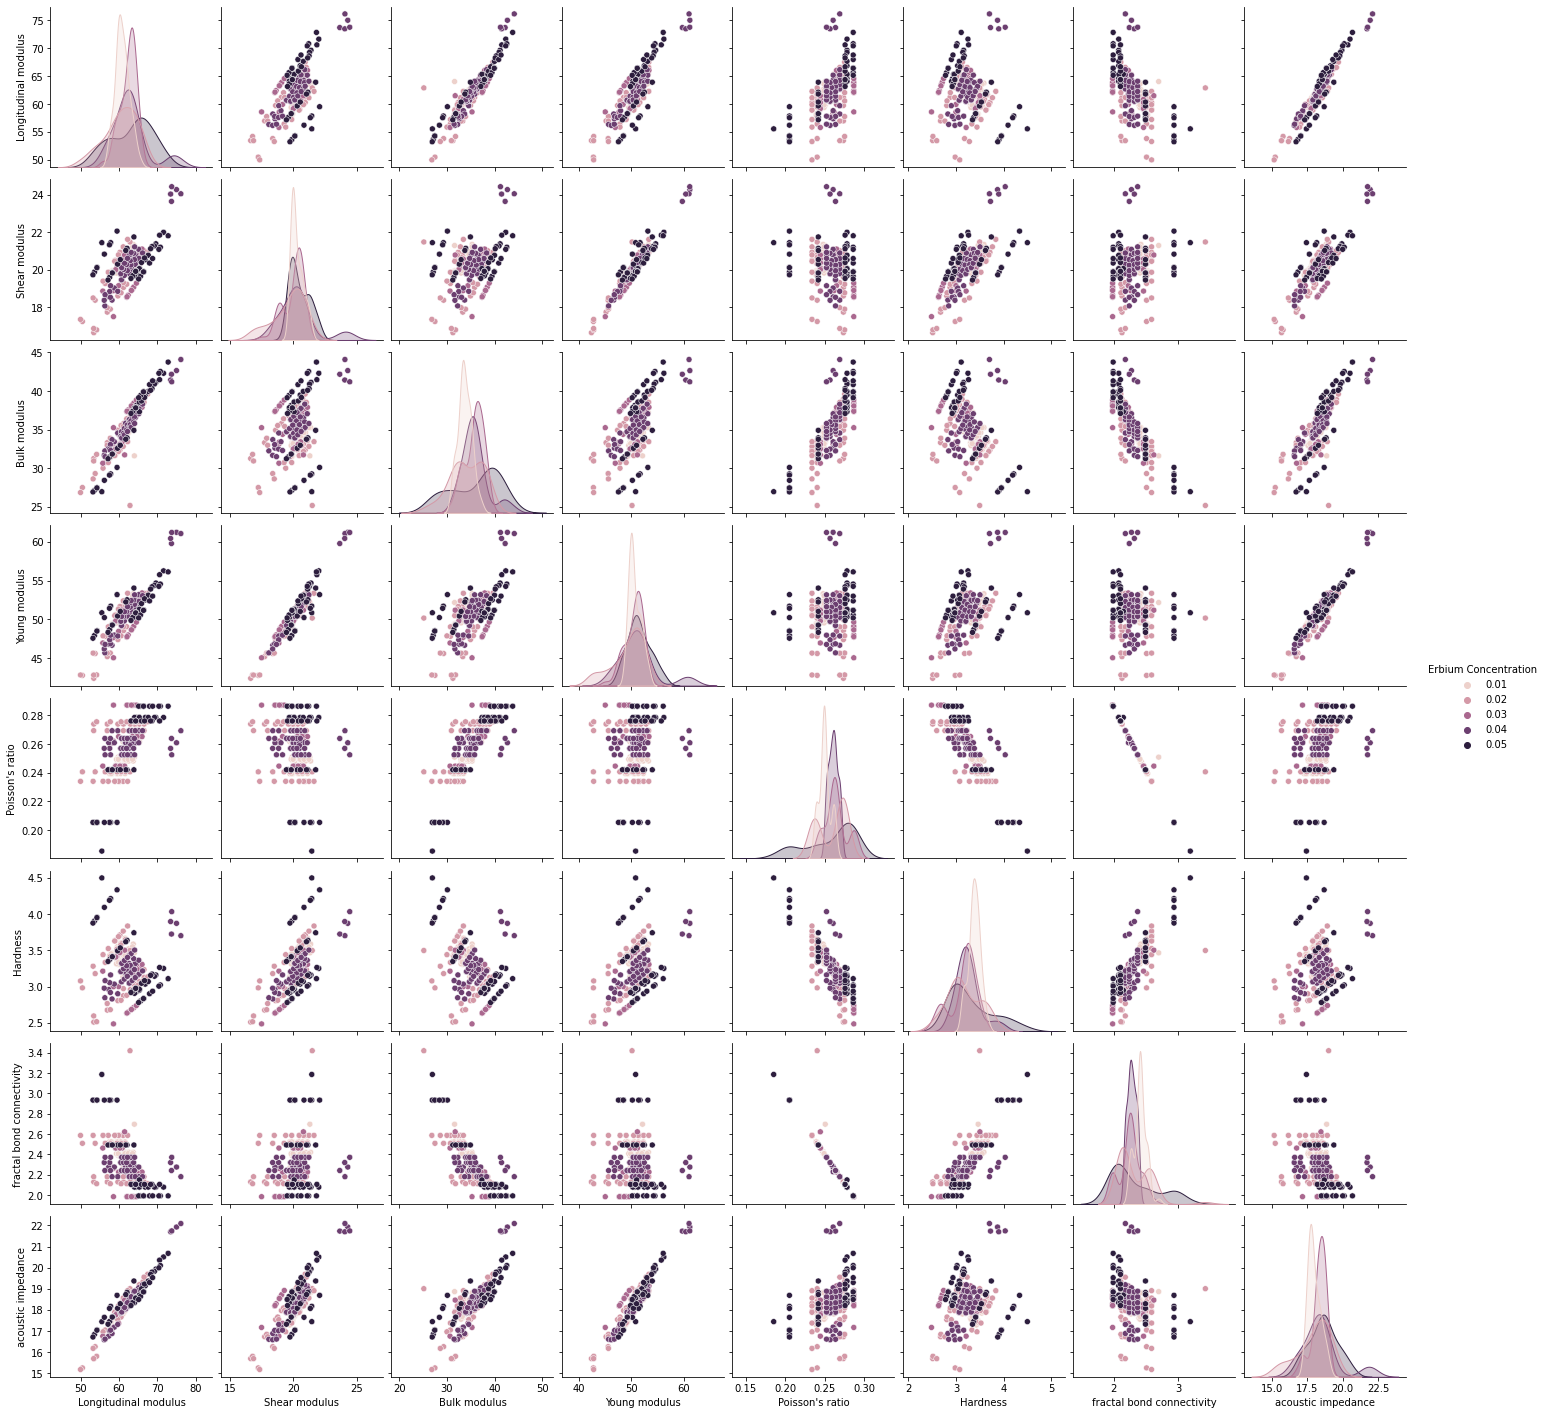

In [3]:
sns.pairplot(data, diag_kind='kde', hue="Erbium Concentration")

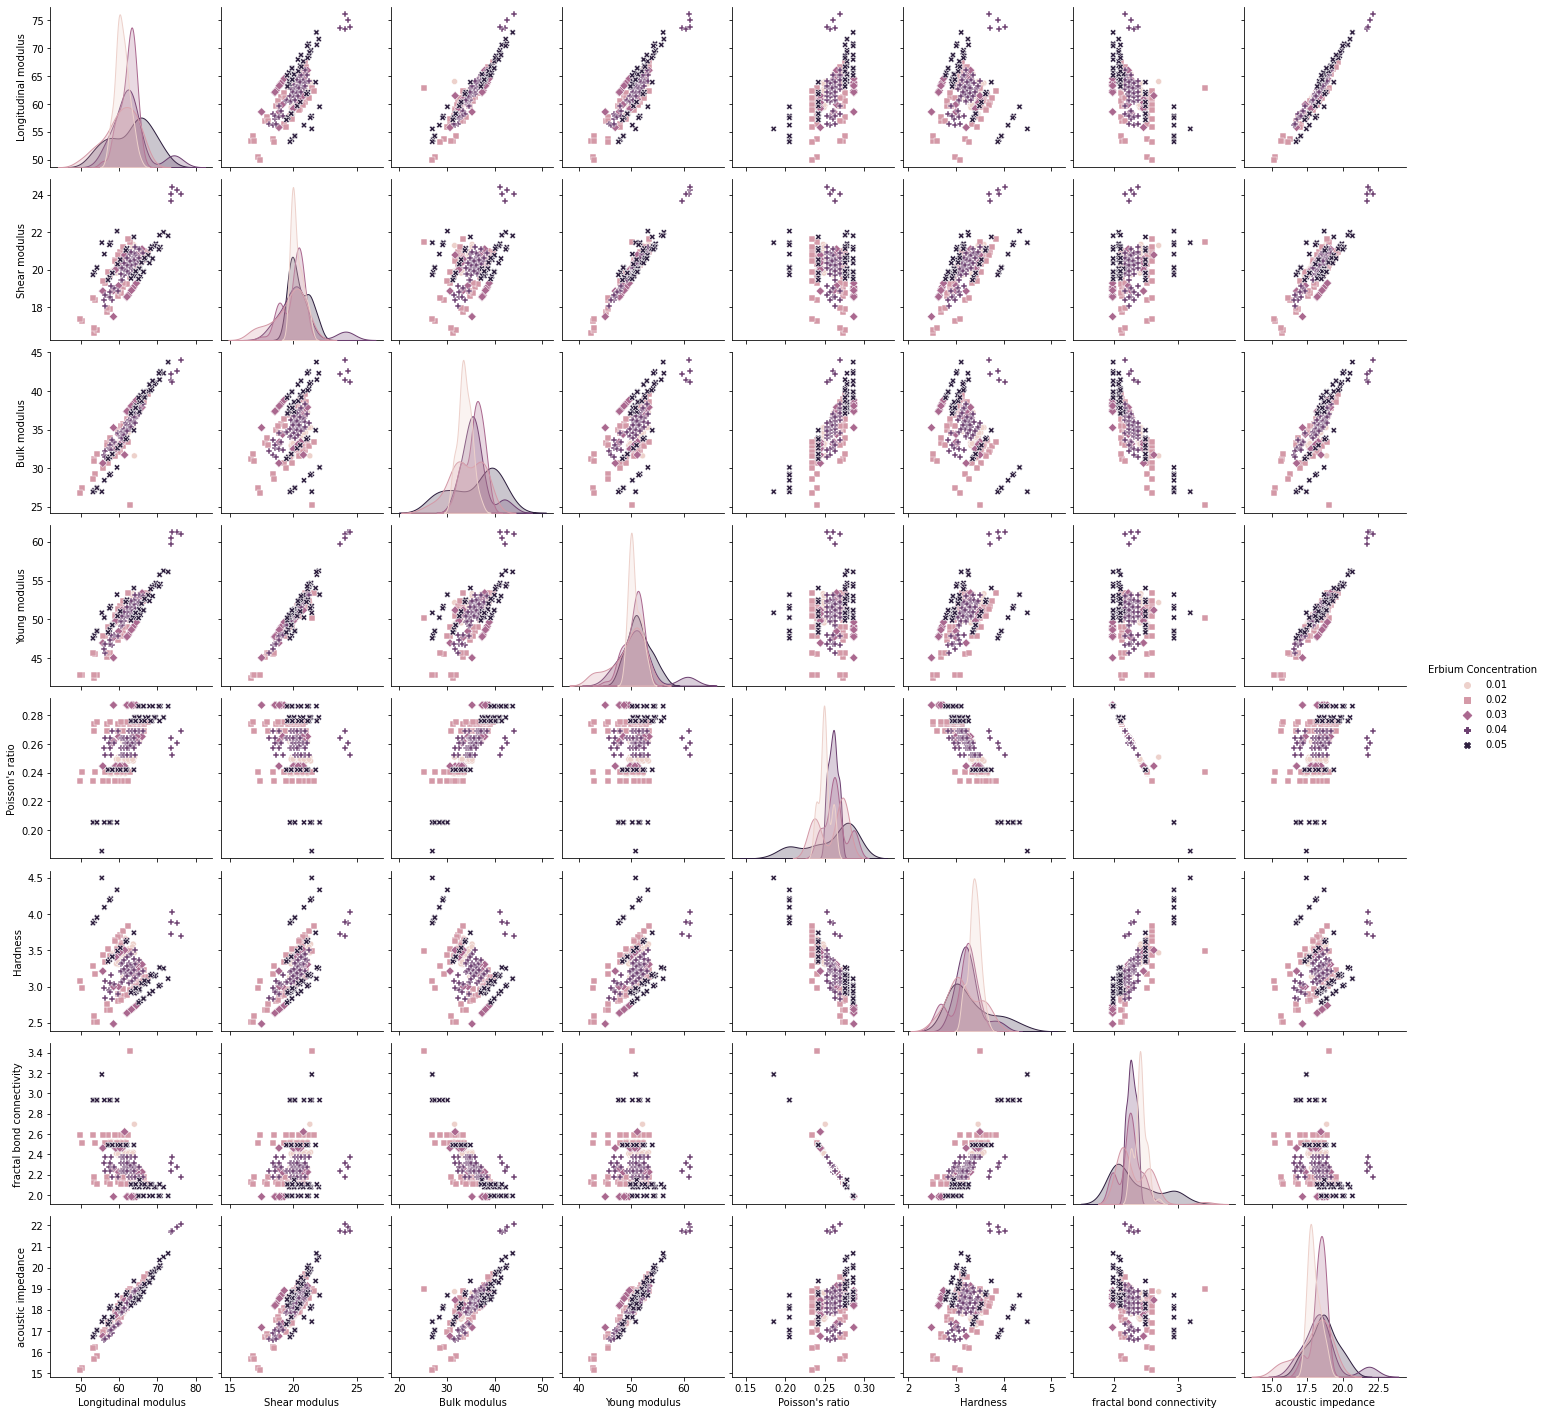

In [4]:
# maybe add some marker
sns.pairplot(data, hue="Erbium Concentration", markers=["o", "s", "D", "P", "X"])

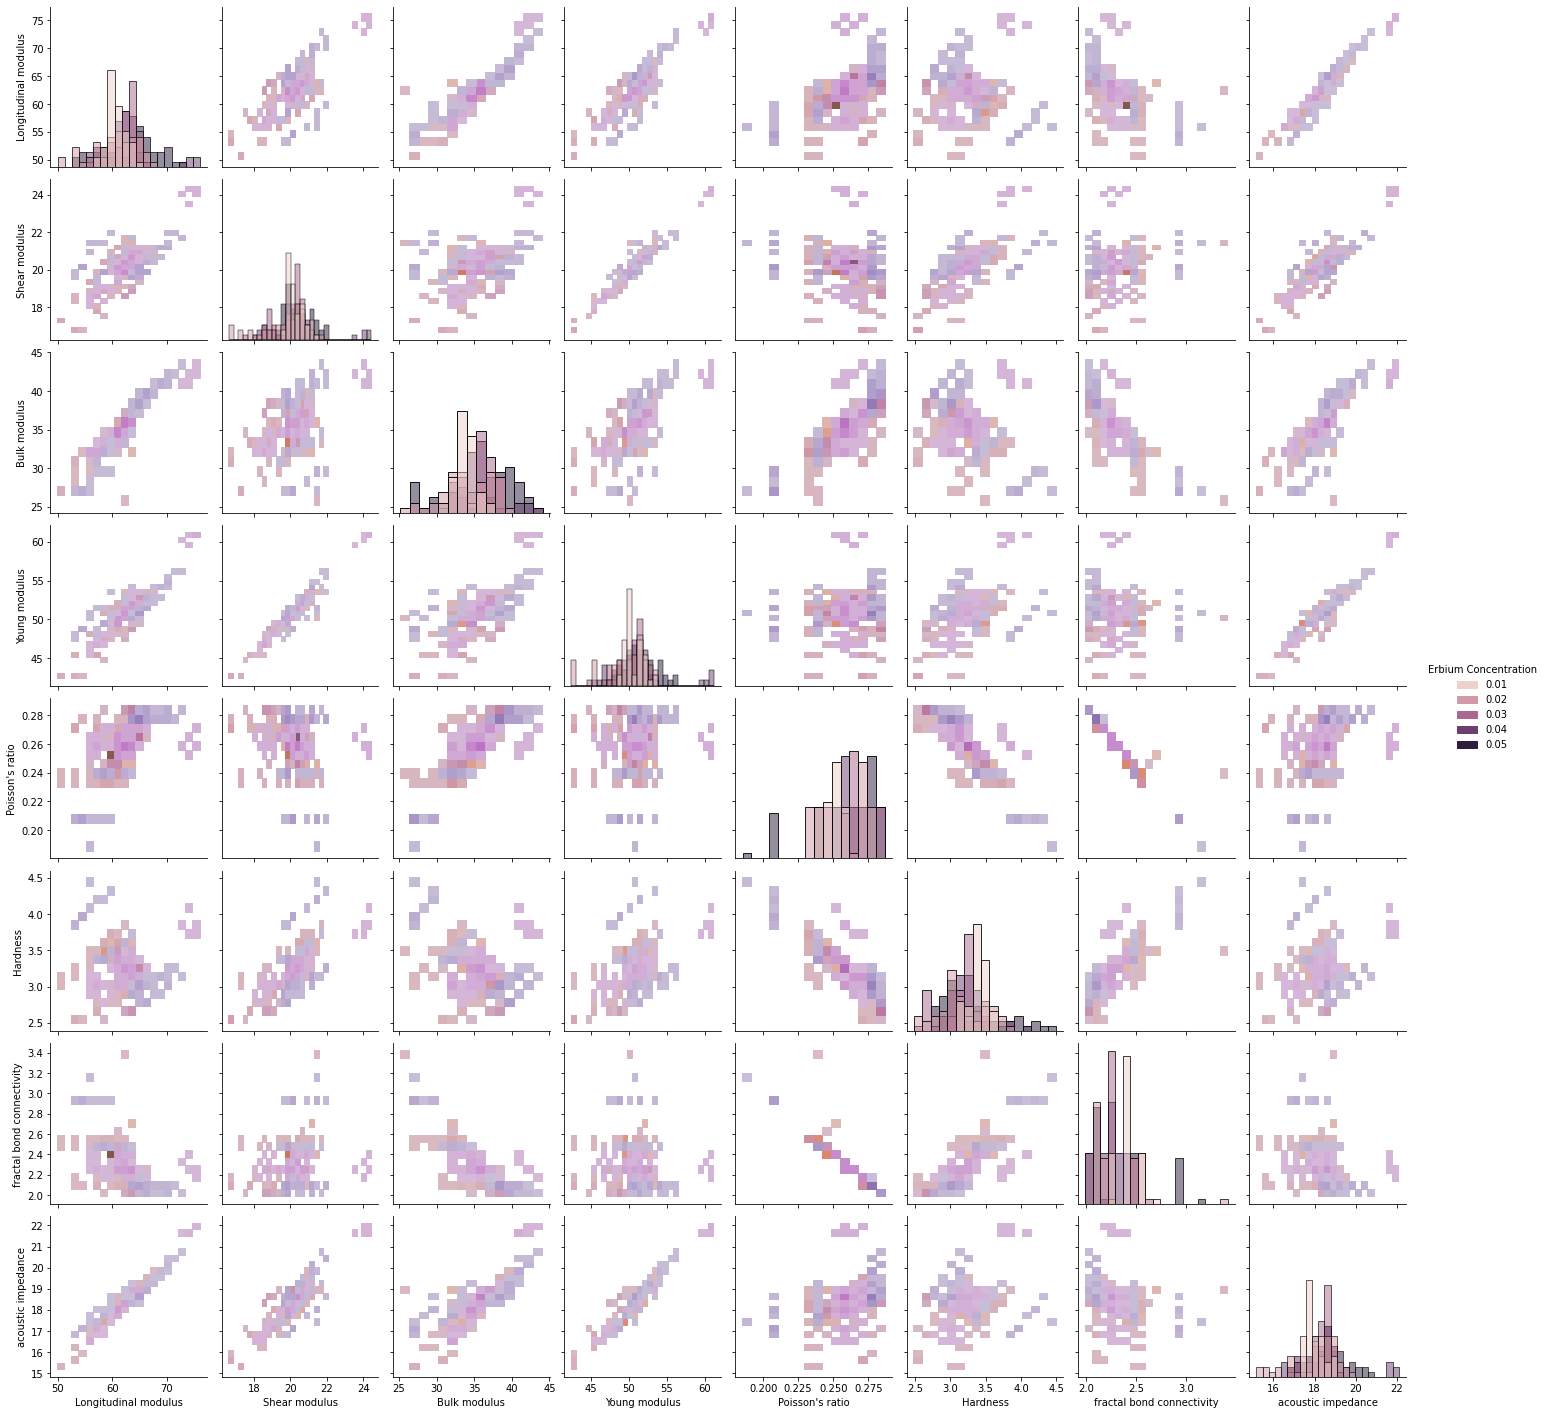

In [5]:
# or maybe histogram
sns.pairplot(data, kind="hist", hue="Erbium Concentration")

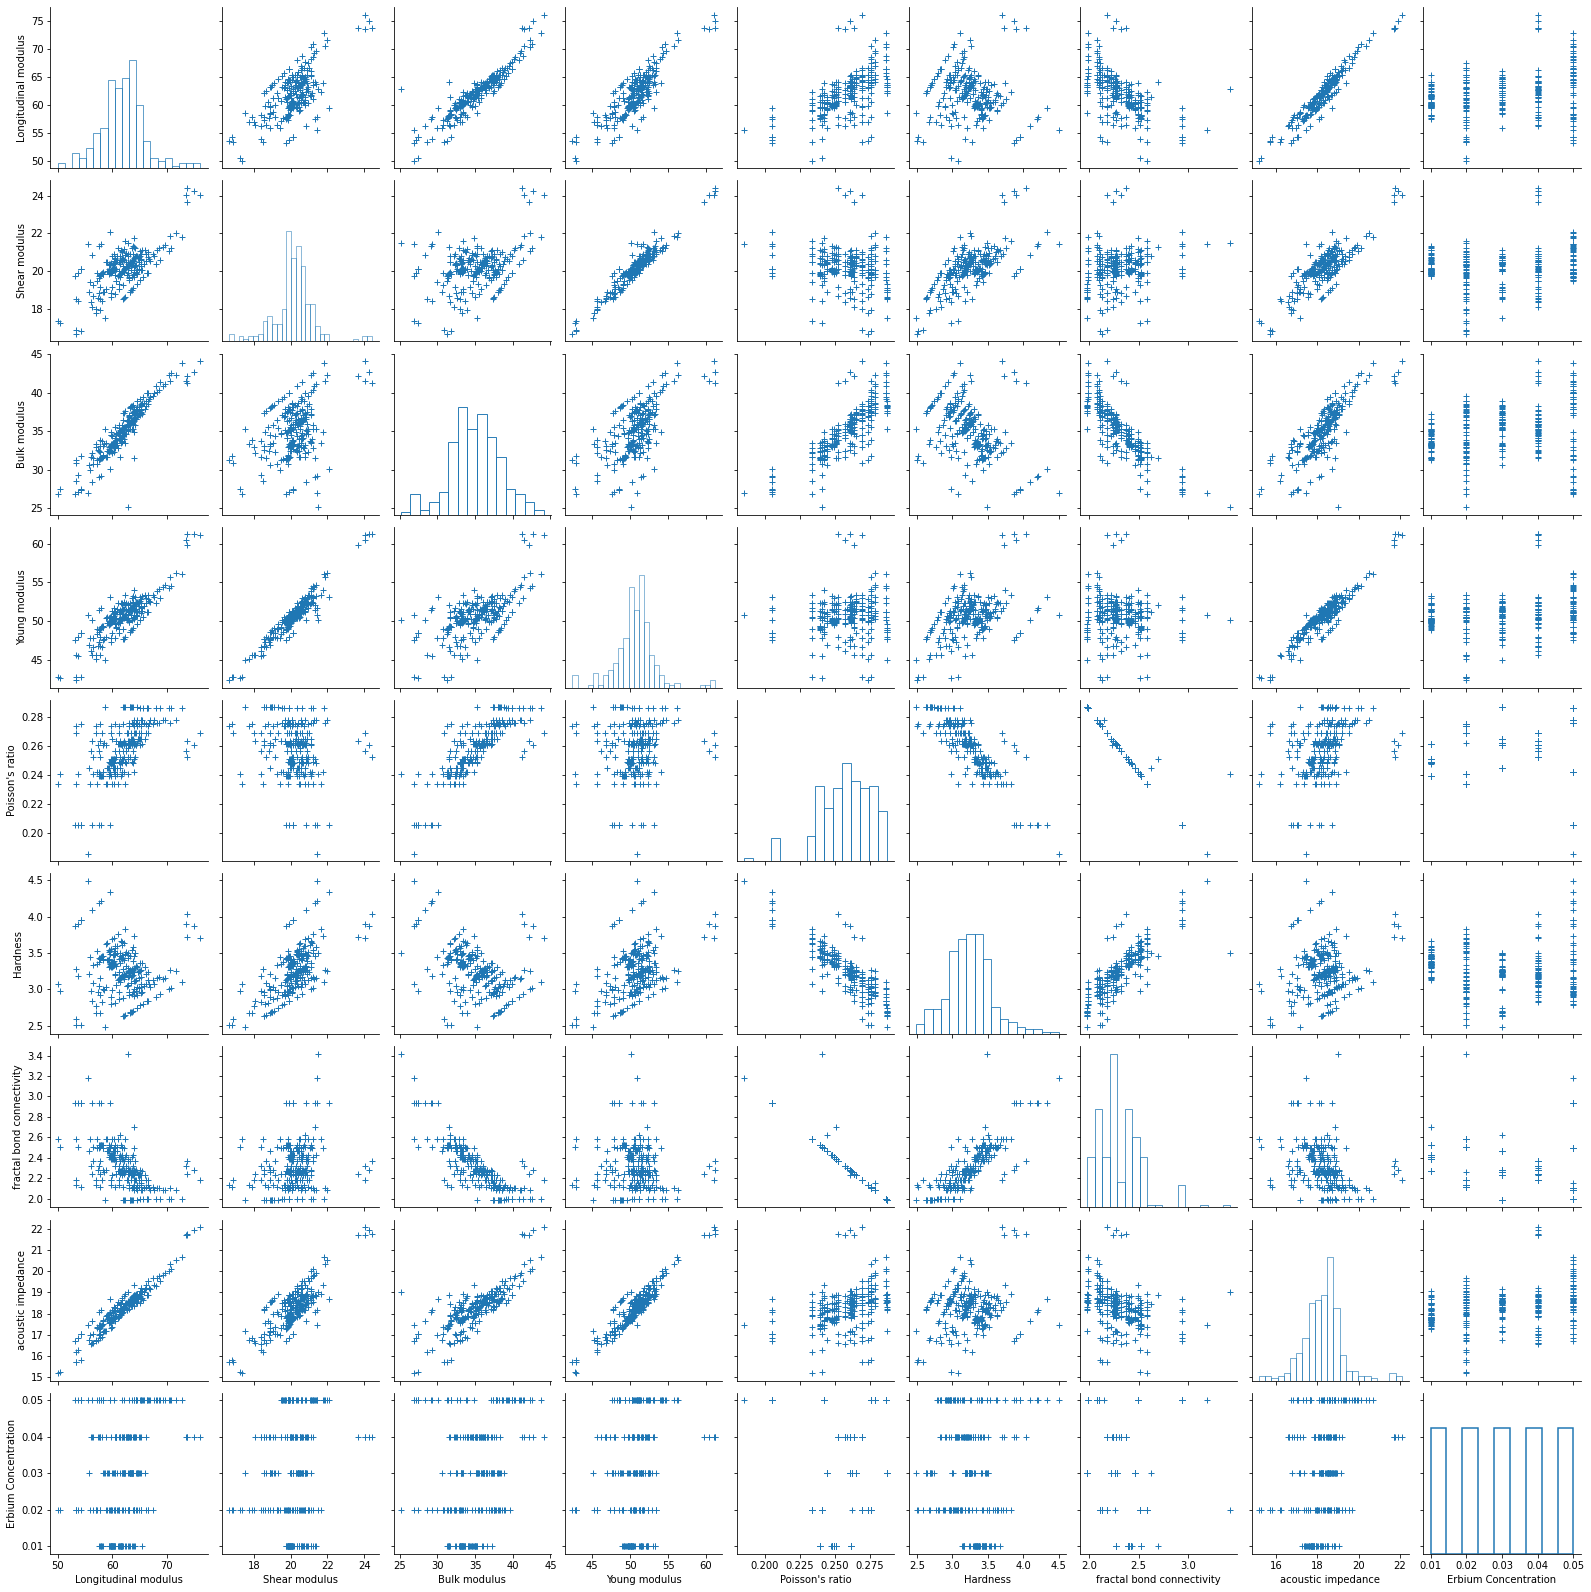

In [8]:
sns.pairplot(data, 
             plot_kws=dict(marker="+", linewidth=1),
             diag_kws=dict(fill=False))

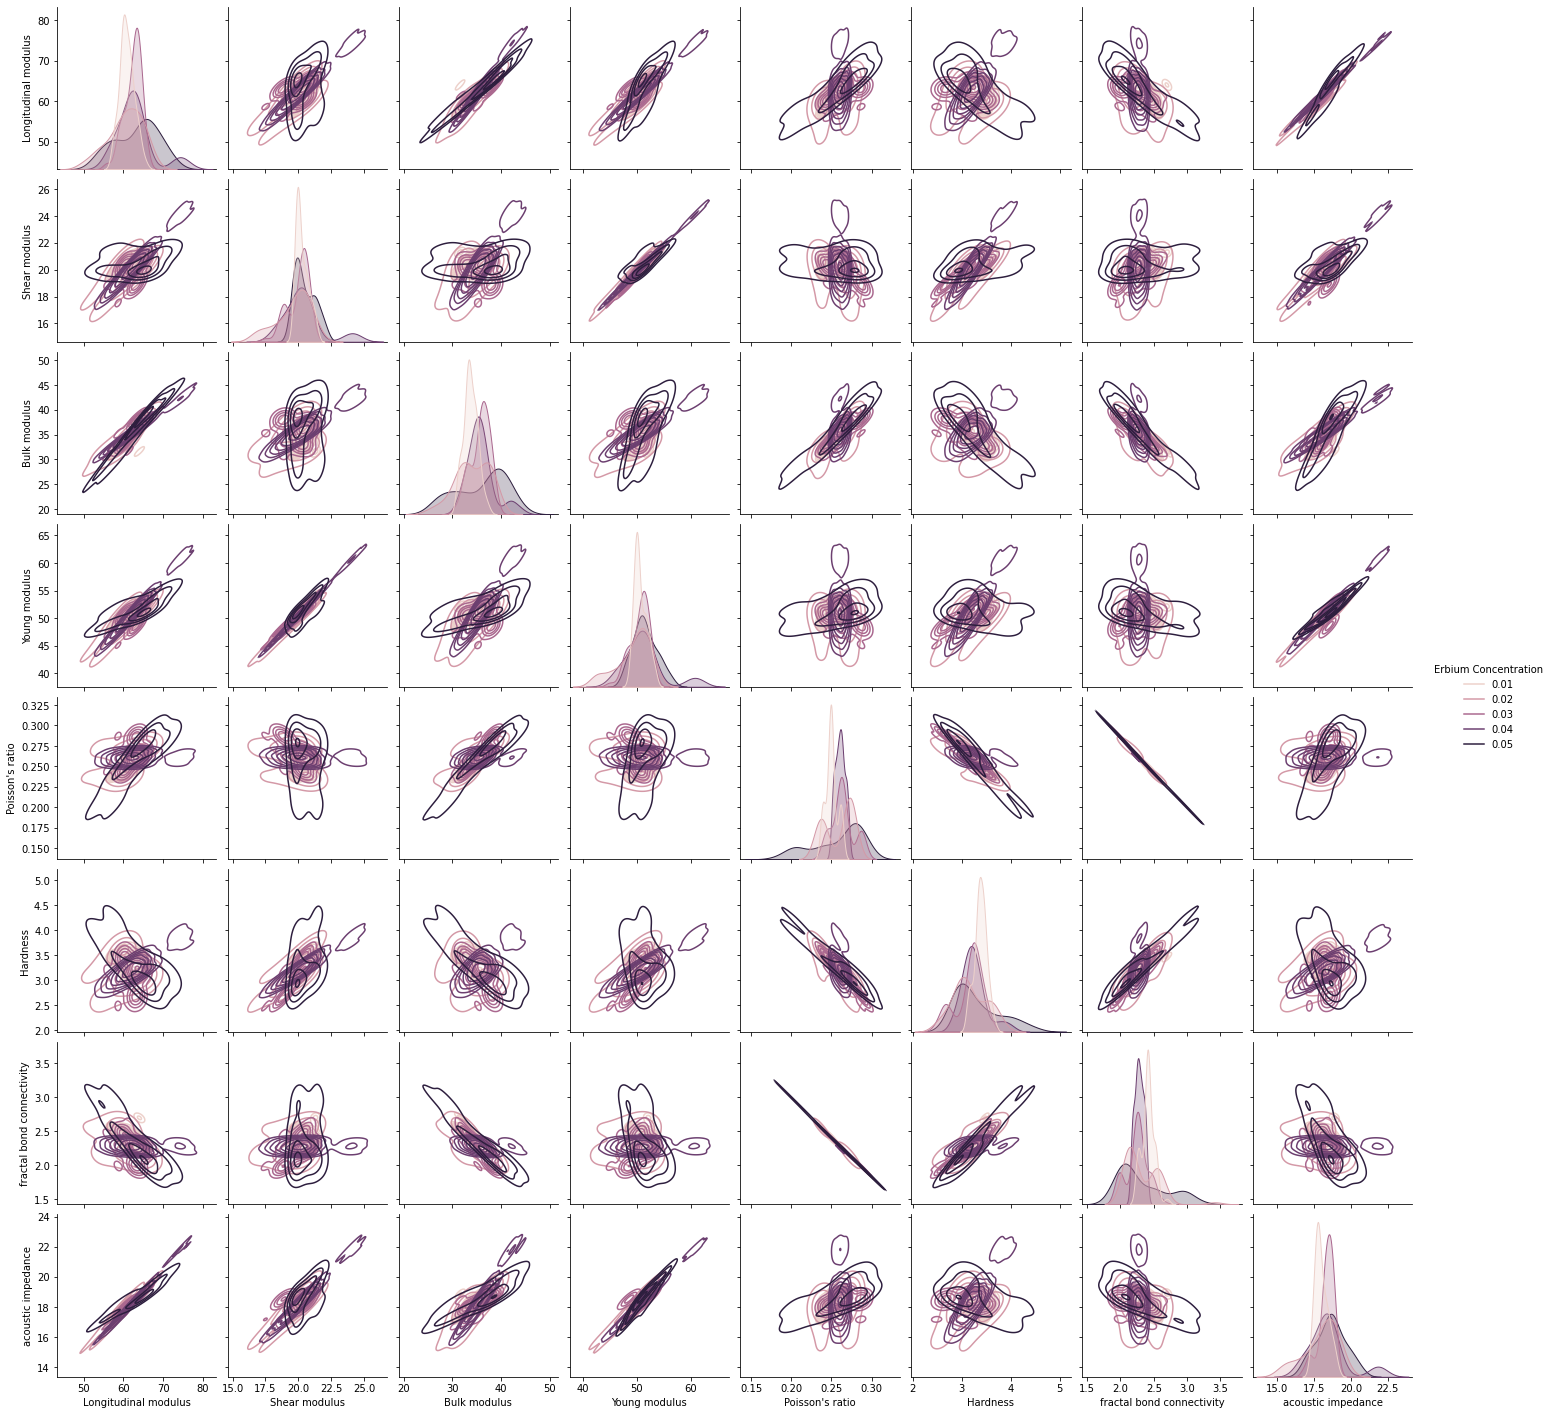

In [10]:
sns.pairplot(data, kind="kde",hue="Erbium Concentration")

In [12]:
train_data = data.sample(frac=0.8, random_state=0)
test_data = data.drop(train_data.index)

train_x = train_data.drop(columns=['Erbium Concentration'],axis=1)
train_y = train_data['Erbium Concentration'].astype(str)

test_x = test_data.drop(columns=['Erbium Concentration'],axis=1)
test_y = test_data['Erbium Concentration'].astype(str)

In [19]:
logistic_reg = LogisticRegression(
                                  penalty='elasticnet',
                                  solver='saga',
                                  l1_ratio=0.1,
                                  max_iter=200,
                                  )
logistic_reg.fit(train_x,train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.1, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
def accuracy(confusion_matrix):
  diagonal_sum = confusion_matrix.trace()
  sum_of_all_elements = confusion_matrix.sum()
  return diagonal_sum / sum_of_all_elements

def test_model(train_data, train_label, test_data, test_label):
  pred_y = logistic_reg.predict(test_data)
  train_acc = logistic_reg.score(train_data, train_label)
  test_acc = logistic_reg.score(test_data, test_label)

  print('Training Accuracy : %.3f'%train_acc)
  print('Test Accuracy : %.3f'%test_acc)

  plt.figure(figsize=(10,7))
  cm = confusion_matrix(pred_y, test_label)
  print("Accuracy score :", accuracy(cm))

  sns.set(font_scale=1.4) # for label size
  sns.heatmap(cm, annot=True, annot_kws={"size": 16})
  plt.show()

Training Accuracy : 0.355
Test Accuracy : 0.240
Accuracy score : 0.24


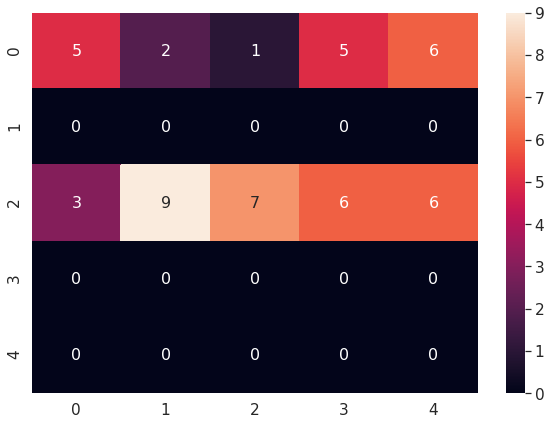

In [21]:
test_model(train_x, train_y, test_x, test_y)

Training Accuracy : 0.210
Test Accuracy : 0.280
Accuracy score : 0.28


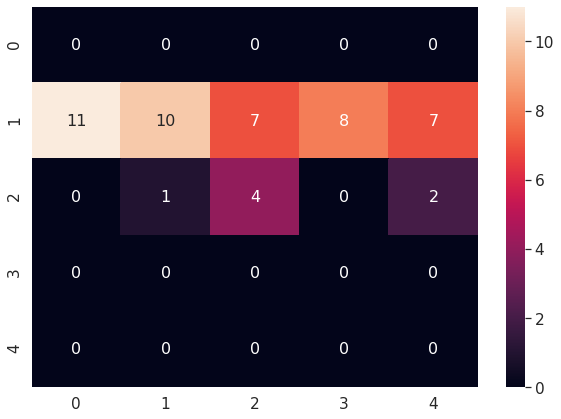

In [22]:
column_name = data.columns[:-1]
df_data = data.copy()
for column in column_name:
    df_data[column] = (df_data[column] - df_data[column].min()) / (df_data[column].max() - df_data[column].min())

normalized_train_data = df_data.sample(frac=0.8, random_state=10)
normalized_test_data = df_data.drop(normalized_train_data.index)

normalized_train_x = normalized_train_data.drop(columns=['Erbium Concentration'],axis=1)
normalized_train_y = normalized_train_data['Erbium Concentration'].astype(str)

normalized_test_x = normalized_test_data.drop(columns=['Erbium Concentration'],axis=1)
normalized_test_y = normalized_test_data['Erbium Concentration'].astype(str)

test_model(normalized_train_x, normalized_train_y, normalized_test_x, normalized_test_y)

In [23]:
parameter_space = {
    'l1_ratio': [0.01, 0.1, 0.2, 0.5, 0.8],
    'max_iter': [100, 200, 300, 500],
    'multi_class': ['auto', 'multinomial'],
}

clf = GridSearchCV(logistic_reg, parameter_space, n_jobs=-1, cv=5)
clf.fit(train_x, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=0.1,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='elasticnet',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'l1_ratio': [0.01, 0.1, 0.2, 0.5, 0.8],
                         'max_iter': [100, 200, 300, 500],
                         'multi_class': ['auto', 'multinomial']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [24]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.335 (+/-0.075) for {'l1_ratio': 0.01, 'max_iter': 100, 'multi_class': 'auto'}
0.335 (+/-0.075) for {'l1_ratio': 0.01, 'max_iter': 100, 'multi_class': 'multinomial'}
0.335 (+/-0.117) for {'l1_ratio': 0.01, 'max_iter': 200, 'multi_class': 'auto'}
0.335 (+/-0.117) for {'l1_ratio': 0.01, 'max_iter': 200, 'multi_class': 'multinomial'}
0.340 (+/-0.121) for {'l1_ratio': 0.01, 'max_iter': 300, 'multi_class': 'auto'}
0.340 (+/-0.121) for {'l1_ratio': 0.01, 'max_iter': 300, 'multi_class': 'multinomial'}
0.360 (+/-0.160) for {'l1_ratio': 0.01, 'max_iter': 500, 'multi_class': 'auto'}
0.360 (+/-0.160) for {'l1_ratio': 0.01, 'max_iter': 500, 'multi_class': 'multinomial'}
0.335 (+/-0.075) for {'l1_ratio': 0.1, 'max_iter': 100, 'multi_class': 'auto'}
0.335 (+/-0.075) for {'l1_ratio': 0.1, 'max_iter': 100, 'multi_class': 'multinomial'}
0.330 (+/-0.116) for {'l1_ratio': 0.1, 'max_iter': 200, 'multi_class': 'auto'}
0.330 (+/-0.116) for {'l1_ratio': 0.1, 'max_iter': 200, 'multi_class': 'multinomial'}
0.

In [25]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'l1_ratio': 0.01, 'max_iter': 500, 'multi_class': 'auto'}


In [44]:
final_logistic_reg = LogisticRegression(
                                  penalty='elasticnet',
                                  solver='saga',
                                  l1_ratio=0.01,
                                  max_iter=6000,
                                  )
final_logistic_reg.fit(train_x,train_y)

pred_y = final_logistic_reg.predict(test_x)
train_acc = final_logistic_reg.score(train_x, train_y)
test_acc = final_logistic_reg.score(test_x, test_y)

print('Training Accuracy : %.3f'%train_acc)
print('Test Accuracy : %.3f'%test_acc)

Training Accuracy : 0.495
Test Accuracy : 0.220


Accuracy score : 0.22


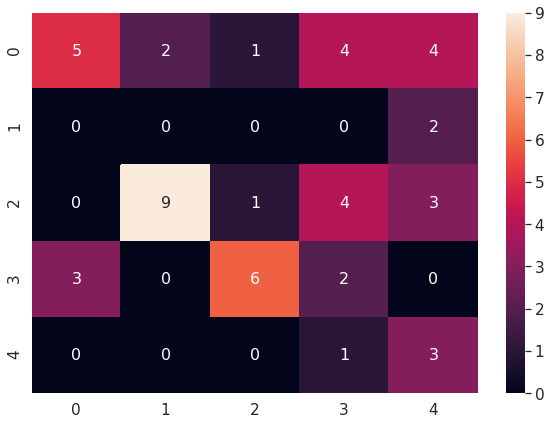

In [45]:
plt.figure(figsize=(10,7))
cm = confusion_matrix(pred_y, test_y)
print("Accuracy score :", accuracy(cm))

sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16})
plt.show()

Training Accuracy : 0.330
Test Accuracy : 0.420
Accuracy score : 0.42


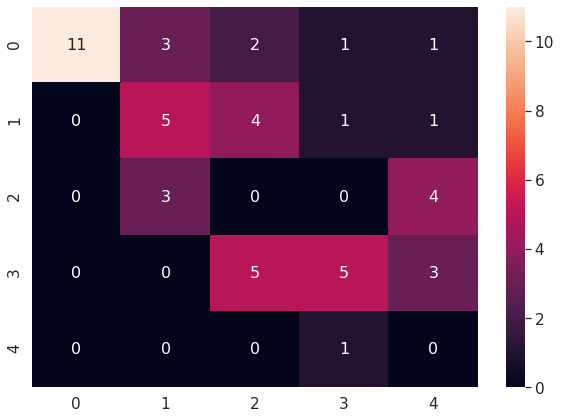

In [46]:
# column_name = data.columns[:-1]
filtered_df_data = data.drop(['Hardness','fractal bond connectivity'], axis=1)

filtered_train_data = filtered_df_data.sample(frac=0.8, random_state=10)
filtered_test_data = filtered_df_data.drop(filtered_train_data.index)

filtered_train_x = filtered_train_data.drop(columns=['Erbium Concentration'],axis=1)
filtered_train_y = filtered_train_data['Erbium Concentration'].astype(str)

filtered_test_x = filtered_test_data.drop(columns=['Erbium Concentration'],axis=1)
filtered_test_y = filtered_test_data['Erbium Concentration'].astype(str)

filter_logistic_reg = LogisticRegression(
                                  penalty='elasticnet',
                                  solver='saga',
                                  l1_ratio=0.01,
                                  max_iter=6000,
                                  )
filter_logistic_reg.fit(filtered_train_x,filtered_train_y)

filtered_pred_y = filter_logistic_reg.predict(filtered_test_x)
filtered_train_acc = filter_logistic_reg.score(filtered_train_x,filtered_train_y)
filtered_test_acc = filter_logistic_reg.score(filtered_test_x, filtered_test_y)

print('Training Accuracy : %.3f'%filtered_train_acc)
print('Test Accuracy : %.3f'%filtered_test_acc)

plt.figure(figsize=(10,7))
filtered_cm = confusion_matrix(filtered_pred_y, np.array(filtered_test_y))
print("Accuracy score :", accuracy(filtered_cm))
sns.set(font_scale=1.4)
sns.heatmap(filtered_cm, annot=True, annot_kws={"size": 16})
plt.show()